## Area Level Cyclability

### Structure

- Get LSOAs / local authority boundaries
- For a single LSOA
    - Get historical data (2016 vs 2021)
    - Some quality checks on data
    - Calculate LTS 2016 vs 2021
    - Analyse impact over time
- Network measures using LTS
    - Connectivity at different LTS levels
    - Other graph measures, separate research to bring in idea/insights for this section

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box, Polygon, MultiPolygon
from shapely.ops import transform
from functools import partial
import pyproj


#Below function from ChatGPT
#Get expanded network - method 1 km buffer
def expand_bbox(original_bbox, expansion_distance_km=5):
    # Create a Shapely geometry object for the original bounding box
    original_geometry = box(*original_bbox)

    # Define a function to project the geometry to a new coordinate reference system
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),  # WGS 84 coordinate reference system
        pyproj.Proj(proj='utm', zone=33, ellps='WGS84')  # Example: UTM Zone 33
    )

    # Project the original geometry to the new coordinate reference system
    projected_geometry = transform(project, original_geometry)

    # Calculate the expansion distance in the projected coordinate system
    expansion_distance_meters = expansion_distance_km * 1000

    # Expand the geometry by the specified distance
    expanded_geometry = projected_geometry.buffer(expansion_distance_meters)

    # Project the expanded geometry back to the original coordinate reference system
    expanded_geometry = transform(partial(pyproj.transform, pyproj.Proj(proj='utm', zone=33, ellps='WGS84'), pyproj.Proj(init='epsg:4326')), expanded_geometry)

    # Get the coordinates of the expanded bounding box
    expanded_bbox = expanded_geometry.bounds

    return expanded_bbox, expanded_geometry

def create_bounding_box(multipolygon1, multipolygon2):
    # Create Shapely geometry objects for each multipolygon
    geometry1 = MultiPolygon(multipolygon1)
    geometry2 = MultiPolygon(multipolygon2)

    # Calculate the union of all polygons in each multipolygon
    union_geometry1 = geometry1.convex_hull
    union_geometry2 = geometry2.convex_hull

    # Calculate the union of the convex hulls of the two multipolygons
    union_geometry = union_geometry1.union(union_geometry2)

    # Get the bounding box of the union geometry
    bounding_box = union_geometry.bounds

    return bounding_box

### Data Imports

In [2]:
# Import MSOA lookup
msoas = gpd.read_file('data/MSOA_EngWal_Dec_2011_Generalised_ClippedEW_0/Middle_Layer_Super_Output_Areas_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp').to_crs(4326).set_index('msoa11cd')

# Import MSOA 2011 OD data
od_data = pd.read_parquet('data/od_2011.parquet')

#Import LSOAs

lsoas = gpd.read_file('data/LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4_6029841263726194941.gpkg').to_crs(4326)
lsoas = pd.concat([lsoas, lsoas.bounds], axis=1)

#Import lsoa to msoa look up

lookup = pd.read_csv('data/PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv')

/tmp/ipykernel_205318/762437366.py:14: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup = pd.read_csv('data/PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv')


### Select a test LSOA

In [3]:
test_lsoa = lookup[lookup['PCD8'] == 'SE15 5PD']
lsoa = lsoas[lsoas['LSOA11CD'] == test_lsoa['LSOA11CD'].values[0]]

# Part 1 - Get data from 2016 and 2021 to make some high level comparisons

### 1.1 Get Data from Within LSOA

In [4]:
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
G_2016 = ox.graph_from_bbox(lsoa['maxy'],lsoa['miny'],lsoa['minx'],lsoa['maxx'],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2016 = ox.graph_to_gdfs(G_2016, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2016[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2016['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2016.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2021-06-01T01:00:00Z"]'
G_2021 = ox.graph_from_bbox(lsoa['maxy'],lsoa['miny'],lsoa['minx'],lsoa['maxx'],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2021 = ox.graph_to_gdfs(G_2021, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2021[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2021['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2021.geojson', driver='GeoJSON')

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


### 1.2 Get Data from Expanded Bounding Box (expand by arbitrary amount)

In [5]:
#Get expanded network

original_bbox = (lsoa['minx'], lsoa['miny'], lsoa['maxx'], lsoa['maxy'])  # Replace with your original bounding box coordinates
expanded_bbox, expanded_geometry = expand_bbox(original_bbox, expansion_distance_km=0.5)
print("Original Bounding Box:", original_bbox)
print("Expanded Bounding Box:", expanded_bbox)

bbox_original = box(lsoa['minx'], lsoa['miny'], lsoa['maxx'], lsoa['maxy'])
gpd.GeoSeries([bbox_original]).to_file('data/outputs/box_orig.geojson', driver='GeoJSON')

box_expanded = box(expanded_bbox[2],expanded_bbox[1],expanded_bbox[0],expanded_bbox[3])
gpd.GeoSeries([box_expanded]).to_file('data/outputs/box_expanded.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
G_2016_exp_buffer = ox.graph_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2016_exp_buffer = ox.graph_to_gdfs(G_2016_exp_buffer, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2016_exp_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2016_exp_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2016_exp_buffer.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2021-06-01T01:00:00Z"]'
G_2021_exp_buffer = ox.graph_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2021_exp_buffer = ox.graph_to_gdfs(G_2021_exp_buffer, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2021_exp_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2021_exp_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2021_exp_buffer.geojson', driver='GeoJSON')

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib

Original Bounding Box: (3968   -0.078855
Name: minx, dtype: float64, 3968    51.470099
Name: miny, dtype: float64, 3968   -0.072779
Name: maxx, dtype: float64, 3968    51.474253
Name: maxy, dtype: float64)
Expanded Bounding Box: (-0.0859587591454154, 51.465662202760164, -0.0656751384452257, 51.47868943075723)


### 1.3 Get Data from Data-Driven Bounding Box Using OD Flow

In [6]:
bike_ods = od_data[(od_data['geo_code1'] == test_lsoa['MSOA11CD'].values[0]) & (od_data['bicycle'] > 0)][['geo_code2','bicycle']].set_index('geo_code2')
bike_ods['geometry'] = msoas['geometry']
bike_ods = bike_ods.dropna()

bike_ods_gdf = gpd.GeoDataFrame(bike_ods, crs="EPSG:4326", geometry=bike_ods['geometry'])
bike_ods_gdf.to_file('data/outputs/od_bike.geojson', driver='GeoJSON')

origin_geom = lsoa['geometry'].values[0]
destination_geom = msoas.loc[bike_ods['bicycle'].idxmax()]['geometry']

bounding_box_od = create_bounding_box(origin_geom, destination_geom)

od_box = box(bounding_box_od[2],bounding_box_od[1],bounding_box_od[0],bounding_box_od[3])
gpd.GeoSeries([od_box]).to_file('data/outputs/box_od.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
G_2016_od_buffer = ox.graph_from_bbox(bounding_box_od[3],bounding_box_od[1],bounding_box_od[2],bounding_box_od[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2016_od_buffer = ox.graph_to_gdfs(G_2016_od_buffer, nodes=True)[1]
edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2016_od_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2016_od_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2016_od_buffer.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2021-06-01T01:00:00Z"]'
G_2021_od_buffer = ox.graph_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2021_od_buffer = ox.graph_to_gdfs(G_2021_od_buffer, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2021_od_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2021_od_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2021_od_buffer.geojson', driver='GeoJSON')

### 1.4 Compare 2016 vs 2021 data at all levels

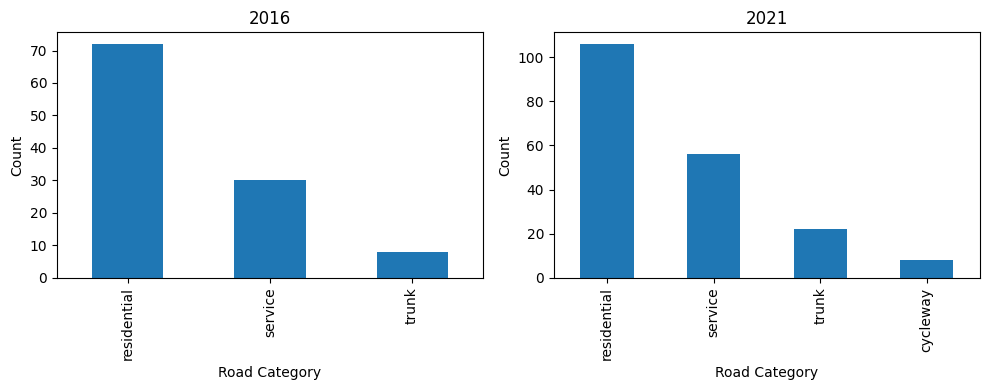

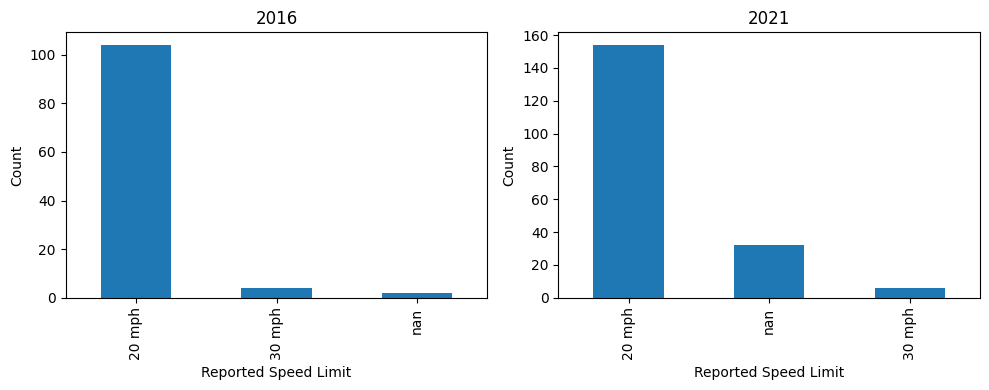

In [7]:
# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016['highway'].value_counts()
value_counts_2021 = edge_attributes_2021['highway'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Road Category')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Road Category')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016['maxspeed'].value_counts(dropna = False)
value_counts_2021 = edge_attributes_2021['maxspeed'].value_counts(dropna = False)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Reported Speed Limit')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Reported Speed Limit')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

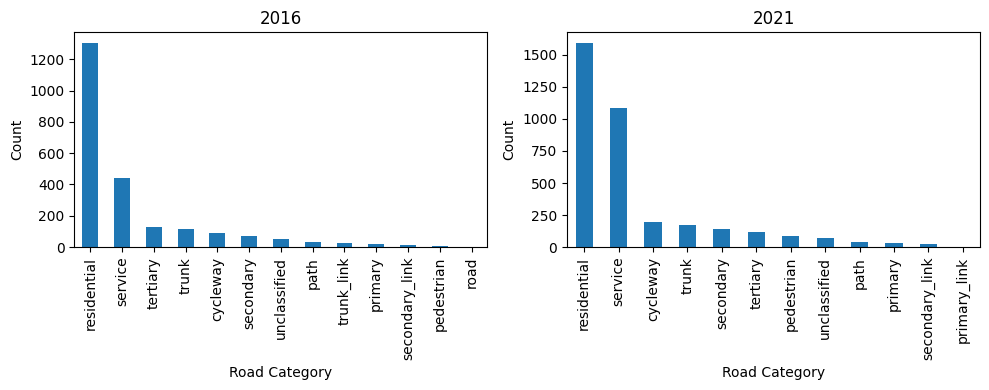

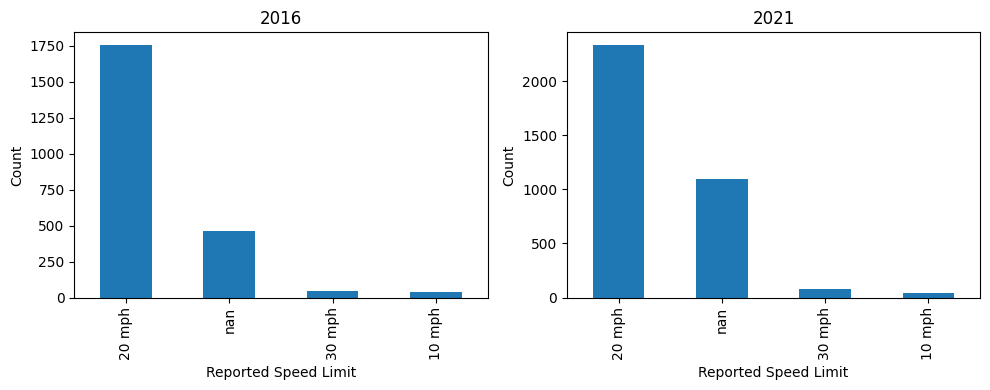

In [8]:
# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016_exp_buffer['highway'].value_counts()
value_counts_2021 = edge_attributes_2021_exp_buffer['highway'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Road Category')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Road Category')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016_exp_buffer['maxspeed'].value_counts(dropna = False)
value_counts_2021 = edge_attributes_2021_exp_buffer['maxspeed'].value_counts(dropna = False)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Reported Speed Limit')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Reported Speed Limit')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

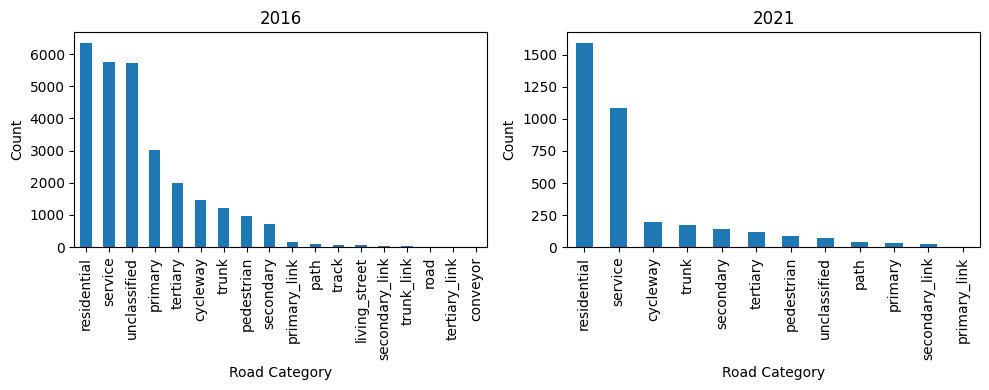

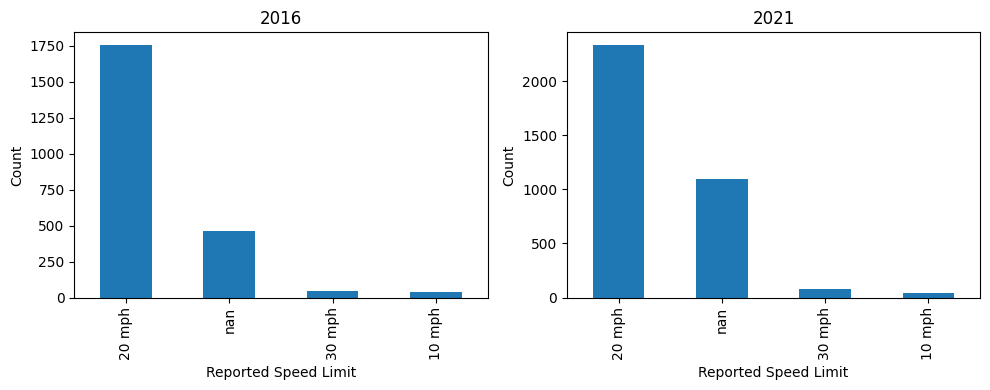

In [9]:
# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016_od_buffer['highway'].value_counts()
value_counts_2021 = edge_attributes_2021_od_buffer['highway'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Road Category')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Road Category')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016_exp_buffer['maxspeed'].value_counts(dropna = False)
value_counts_2021 = edge_attributes_2021_exp_buffer['maxspeed'].value_counts(dropna = False)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Reported Speed Limit')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Reported Speed Limit')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

# Part 2 - Efficiently measure LTS

In [10]:
import OSM2AT

#Cycle network
impute_method = 'mode-rule'
mlp_train_params = {
    'hidden_layer' : 100,
    'n_epochs' : 50,
    'batch_size' : 10
}
lts_method = 'ottawa'
self_learn_k = 5
pull_method = 'bb'
place = None

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:31: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True, useful_tags_way=utw)


### 2.1 LSOA networks

In [13]:
G_2016,edges_2016 = OSM2AT.measure_LTS_from_network(G_2016,impute_method,mlp_train_params,lts_method,self_learn_k)
G_2021,edges_2021 = OSM2AT.measure_LTS_from_network(G_2021,impute_method,mlp_train_params,lts_method,self_learn_k)

Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing Surface
Index(['osmid', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'reversed',
       'length', 'geometry', 'cent_x', 'cent_y', 'edge_index', 'lanes'],
      dtype='object')
Calculating LTS using Ottawa Advocacy Group method


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


### 2.2 Expanded LSOA networks

In [15]:
#Expanded
G_2016_exp_buffer,edges_2016_exp_buffer = OSM2AT.measure_LTS_from_network(G_2016_exp_buffer,impute_method,mlp_train_params,lts_method,self_learn_k)
G_2021_exp_buffer,edges_2021_exp_buffer = OSM2AT.measure_LTS_from_network(G_2021_exp_buffer,impute_method,mlp_train_params,lts_method,self_learn_k)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing data using method - Mode Rule
Data imputed
Imputing Surface
Index(['osmid', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'reversed',
       'length', 'service', 'lanes', 'bridge', 'est_width', 'access',
       'geometry', 'cent_x', 'cent_y', 'edge_index'],
      dtype='object')
Calculating LTS using Ottawa Advocacy Group method


### 2.3 Expanded OD networks

In [17]:
#OD box
G_2016_od_buffer,edges_2016_od_buffer = OSM2AT.measure_LTS_from_network(G_2016_od_buffer,impute_method,mlp_train_params,lts_method,self_learn_k)
G_2021_od_buffer,edges_2021_od_buffer = OSM2AT.measure_LTS_from_network(G_2021_od_buffer,impute_method,mlp_train_params,lts_method,self_learn_k)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing data using method - Mode Rule
Data imputed
Imputing Surface
Index(['osmid', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'oneway',
       'reversed', 'length', 'bridge', 'access', 'tunnel', 'junction', 'width',
       'est_width', 'service', 'area', 'geometry', 'cent_x', 'cent_y',
       'edge_index'],
      dtype='object')
Calculating LTS using Ottawa Advocacy Group method


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing data using method - Mode Rule
Data imputed
Imputing Surface
Index(['osmid', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'reversed',
       'length', 'service', 'lanes', 'bridge', 'est_width', 'access', 'tunnel',
       'geometry', 'cent_x', 'cent_y', 'edge_index'],
      dtype='object')
Calculating LTS using Ottawa Advocacy Group method


### 2.4 View Distribution of LTS

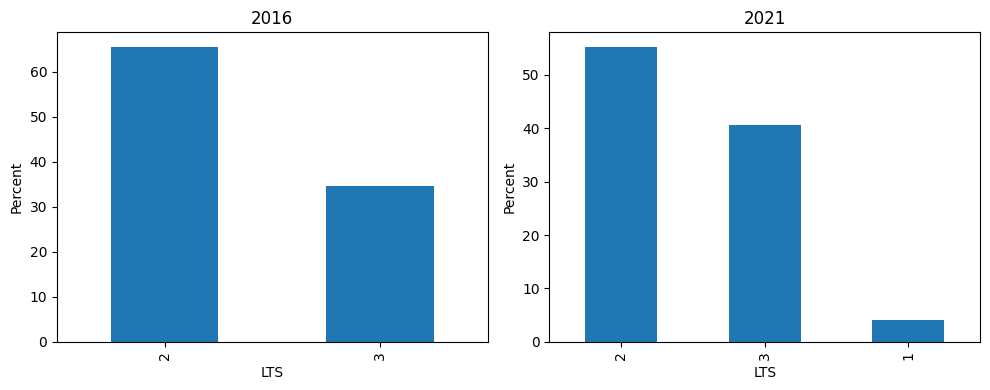

In [36]:
# Use value_counts to get counts of each category
value_counts1 = edges_2016['LTS'].value_counts()
value_counts2 = edges_2021['LTS'].value_counts()

# Calculate percentages
percentage1 = (value_counts1 / value_counts1.sum()) * 100
percentage2 = (value_counts2 / value_counts2.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage1.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage2.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

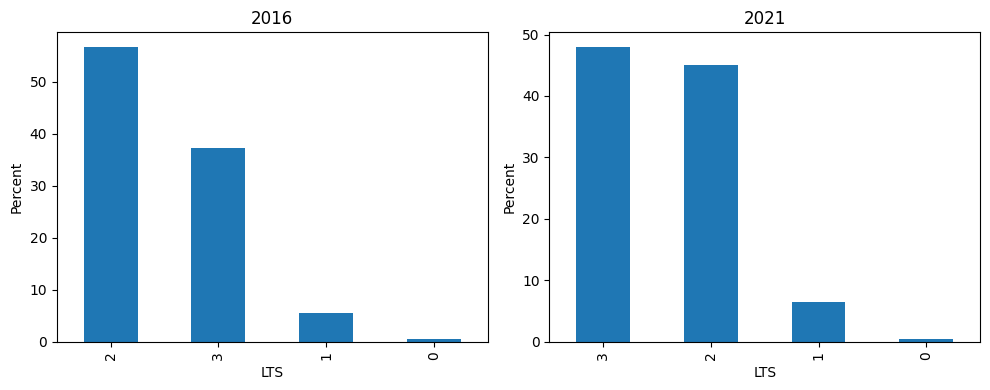

In [34]:
# Use value_counts to get counts of each category
value_counts1 = edges_2016_exp_buffer['LTS'].value_counts()
value_counts2 = edges_2021_exp_buffer['LTS'].value_counts()

# Calculate percentages
percentage1 = (value_counts1 / value_counts1.sum()) * 100
percentage2 = (value_counts2 / value_counts2.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage1.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage2.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

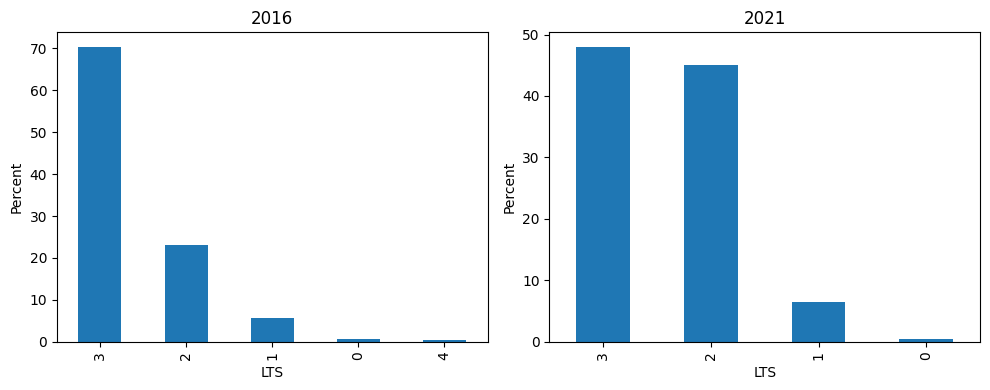

In [35]:
# Use value_counts to get counts of each category
value_counts1 = edges_2016_od_buffer['LTS'].value_counts()
value_counts2 = edges_2021_od_buffer['LTS'].value_counts()

# Calculate percentages
percentage1 = (value_counts1 / value_counts1.sum()) * 100
percentage2 = (value_counts2 / value_counts2.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage1.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage2.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

### 2.5 View Distribution of LTS Kilometres on Roads

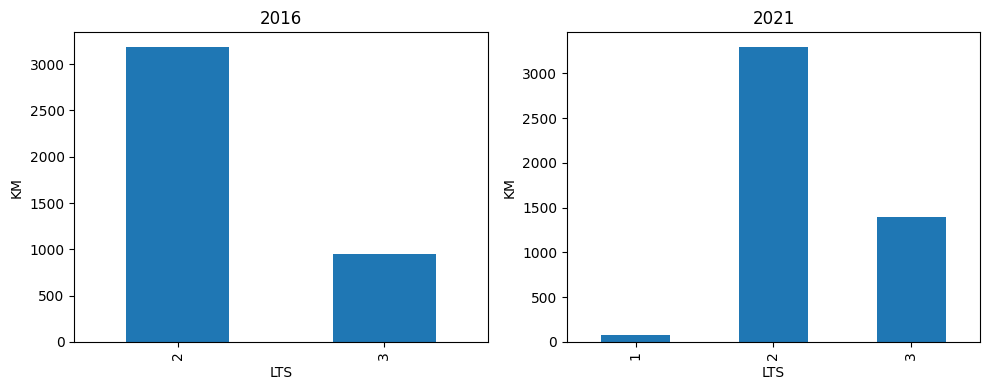

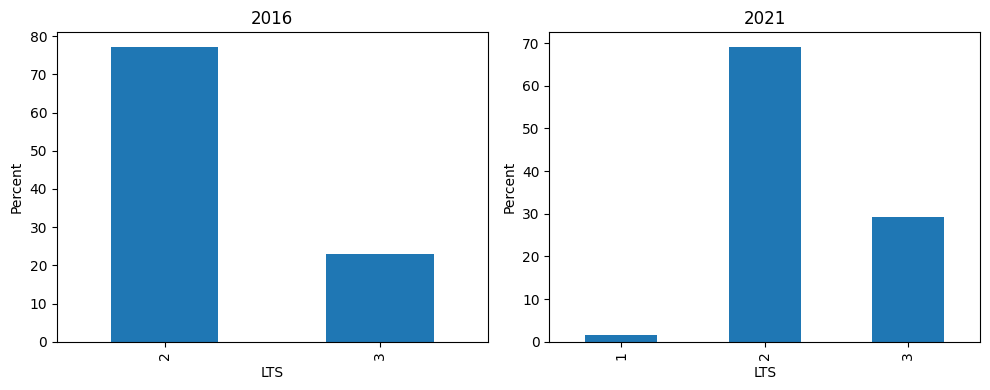

In [41]:
grouped_data_2016 = edges_2016.groupby('LTS')['length'].sum()
grouped_data_2021 = edges_2021.groupby('LTS')['length'].sum()

# Calculate percentages
percentage_2016 = (grouped_data_2016 / grouped_data_2016.sum()) * 100
percentage_2021 = (grouped_data_2021 / grouped_data_2021.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

grouped_data_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('KM')
axs[0].set_title('2016')

grouped_data_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('KM')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

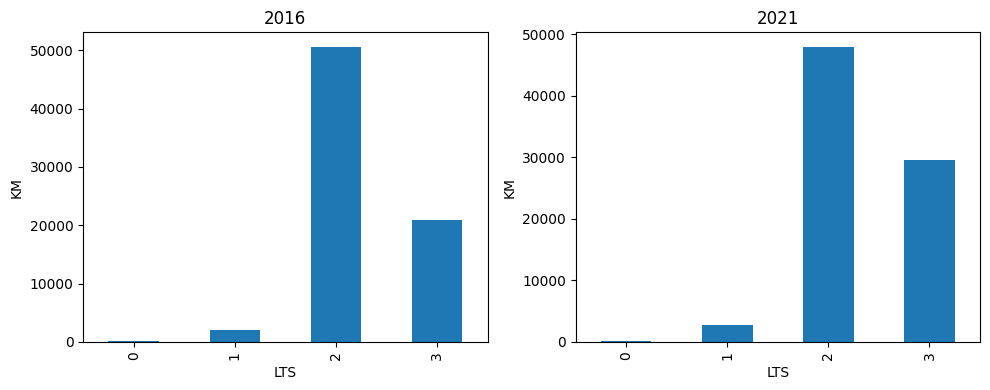

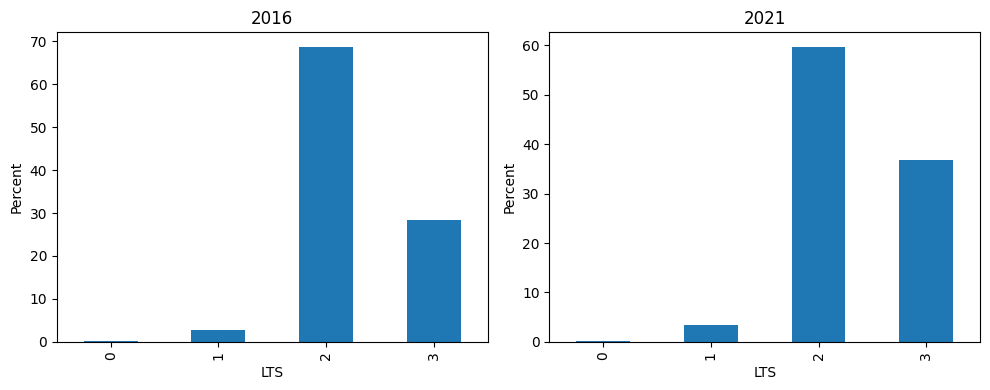

In [42]:
grouped_data_2016 = edges_2016_exp_buffer.groupby('LTS')['length'].sum()
grouped_data_2021 = edges_2021_exp_buffer.groupby('LTS')['length'].sum()

# Calculate percentages
percentage_2016 = (grouped_data_2016 / grouped_data_2016.sum()) * 100
percentage_2021 = (grouped_data_2021 / grouped_data_2021.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

grouped_data_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('KM')
axs[0].set_title('2016')

grouped_data_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('KM')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

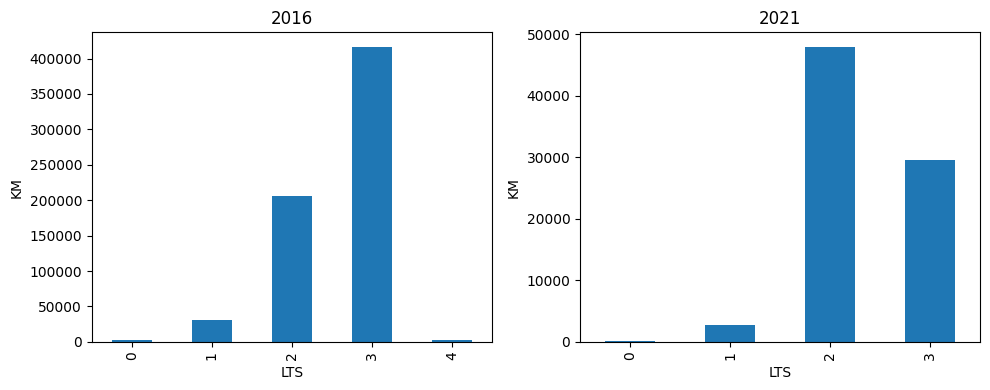

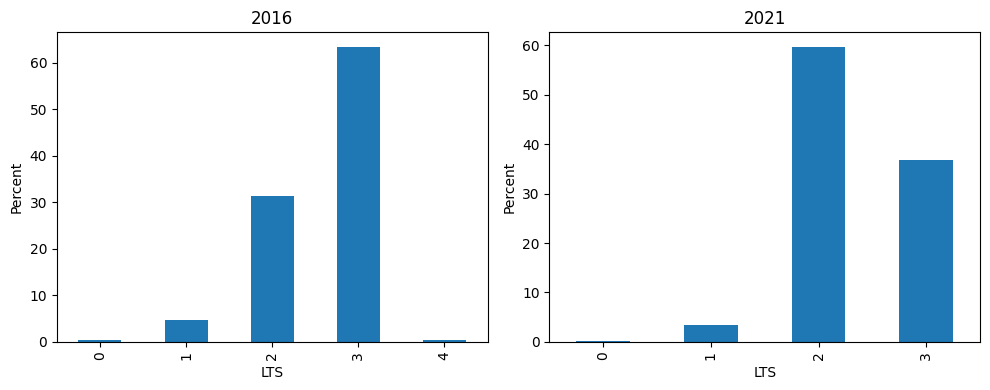

In [43]:
grouped_data_2016 = edges_2016_od_buffer.groupby('LTS')['length'].sum()
grouped_data_2021 = edges_2021_od_buffer.groupby('LTS')['length'].sum()

# Calculate percentages
percentage_2016 = (grouped_data_2016 / grouped_data_2016.sum()) * 100
percentage_2021 = (grouped_data_2021 / grouped_data_2021.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

grouped_data_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('KM')
axs[0].set_title('2016')

grouped_data_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('KM')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

# Part 3 - Routing Analysis

- Bring in buildings in LSOA
- Route to nearby POIs (e.g., shops, schools, train stations)
- Route to main desination point
    - Get top k routes
    - If time get pareto curve

In [44]:
# Get buildings 2016 - LSOA level
tags = {'building': True}
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
buildings_lsoa = ox.features.features_from_bbox(lsoa['maxy'],lsoa['miny'],lsoa['minx'],lsoa['maxx'], tags)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [49]:
# Get shops - expanded network
tags = {'railway': 'station'}
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
station_exp_area = ox.features.features_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0], tags)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.

In [51]:
# Get train station - expanded network
tags = {'shop': 'supermarket'}
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
supermarkets_exp_area = ox.features.features_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0], tags)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.

In [52]:
# Get schools - expanded network
tags = {'amenity': 'school'}
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
school_exp_area = ox.features.features_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0], tags)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.

In [ ]:


    reachable_123 = 0
    reachable_12 = 0
    num_building = 0
    building_points_x = []
    building_points_y = []
    for i in list(buildings['geometry']):
        nearest_point_on_line, _ = nearest_points(i, sensor_point)
        building_points_x.append(nearest_point_on_line.x)
        building_points_y.append(nearest_point_on_line.y)
        
    building_nodes = ox.distance.nearest_nodes(G, building_points_x, building_points_y, return_dist=False)

    reachable_123 = 0
    reachable_12 = 0
    num_building = 0
    for i in building_nodes:
        if i in nodes_reached_lts_123:
            reachable_123 += 1
        if i in nodes_reached_lts_12:
            reachable_12 += 1
            
        num_building += 1

    percent_reachable_lts_123 = (reachable_123 / len(buildings)) * 100
    percent_reachable_lts_12 = (reachable_12 / len(buildings)) * 100

# Part 4 - Centrlity Analysis

- Simple centrality measure
- LTS weighted centrality